In [63]:
import numpy as np
import pandas as pd
import sklearn.linear_model as skl_lm
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [64]:
df = pd.read_csv('data/Default.csv')

# We set the first column as the index since it is not a variable
df.set_index('Unnamed: 0', inplace=True)

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object.
# We transform 'No' to 0 and 'Yes' to 1
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df[['default2','default','student2','student']].head()
df.head(3)

,default,student,balance,income,default2,student2
Unnamed: 0,,,,,,
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


In [65]:
# A look to the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   default   10000 non-null  object 
 1   student   10000 non-null  object 
 2   balance   10000 non-null  float64
 3   income    10000 non-null  float64
 4   default2  10000 non-null  int64  
 5   student2  10000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 546.9+ KB


In [66]:
# We remove null values for the balance and income variables
df.dropna(subset=['balance', 'income'], inplace=True)  # Inplace=True modifies the DataFrame

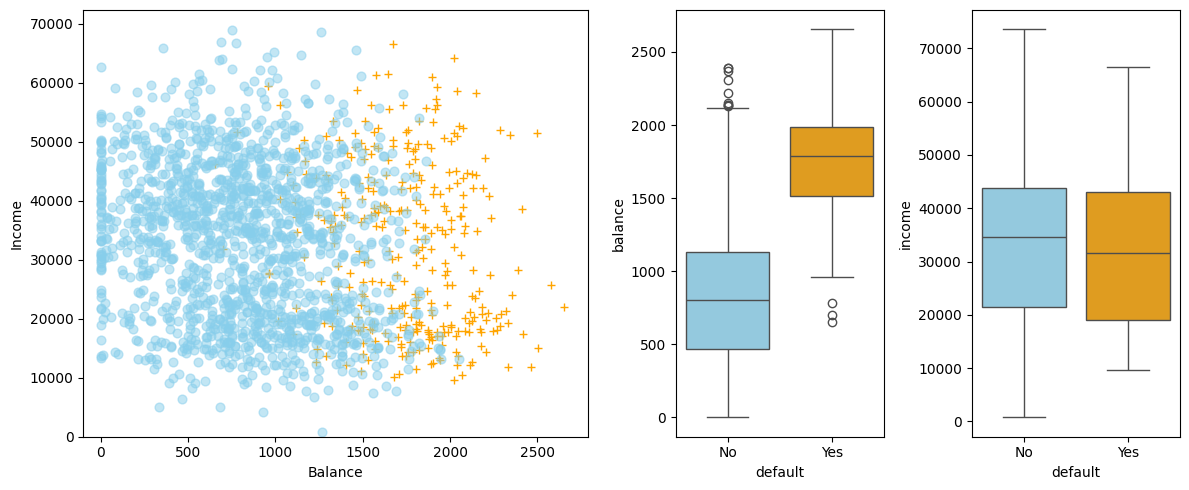

In [67]:
# Let's have a look to the data
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = pd.concat([df_no, df_yes])

ax1.scatter(x=df_[df_.default == 'Yes'].balance, y=df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)

ax1.scatter(x=df_[df_.default == 'No'].balance, y=df_[df_.default == 'No'].income, alpha=.5, s=40, c='skyblue', marker='o',)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'skyblue', 'Yes':'orange'}
sns.boxplot(x='default', y='balance', data=df, orient='v', ax=ax2, hue = 'default', palette=c_palette, legend=False)
sns.boxplot(x='default', y='income', data=df, orient='v', ax=ax3, hue = 'default', palette=c_palette, legend=False)
gs.tight_layout(plt.gcf())

## Train and test split
We now work with balance as X and default as y

In [68]:
# We assign the variables X and y
x = df.balance.values.reshape(-1,1) # scikit-learn expects a 2D array not a pd.Series :(
y = df.default2

x

array([[ 729.52649521],
       [ 817.18040656],
       [1073.54916401],
       ...,
       [ 845.41198922],
       [1569.00905338],
       [ 200.92218263]])

In [69]:
# We now divide in train and test sets 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Fit the model

In [70]:
# Fit the model
clf = skl_lm.LogisticRegression()
clf.fit(X_train,y_train)


LogisticRegression()

In [71]:
x_proba = clf.predict_proba([X_train[0]])
x_pred = clf.predict([X_train[0]])

print('Class Order:', clf.classes_)
print('Odds:', x_proba)
print('Model prediction:', x_pred)

Class Order: [0 1]
Odds: [[0.99431548 0.00568452]]
Model prediction: [0]


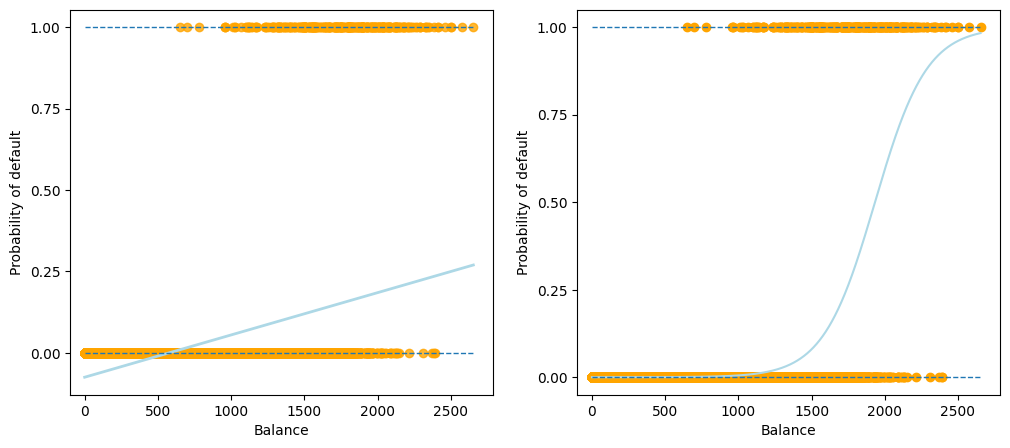

In [72]:
X_space = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)
prob = clf.predict_proba(X_space)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(x=df.balance, y=df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(x, y, color='orange')
ax2.plot(X_space, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

In [73]:
# Let's suppose we have a new observation with balance = 1500
# We can calculate the probability of default
new_balance_obs = 1700
prob_new_obs = clf.predict_proba([[new_balance_obs]])[:,1][0]
print('Prob of default with balance = 1500:', prob_new_obs)

Prob of default with balance = 1500: 0.21153414117227223


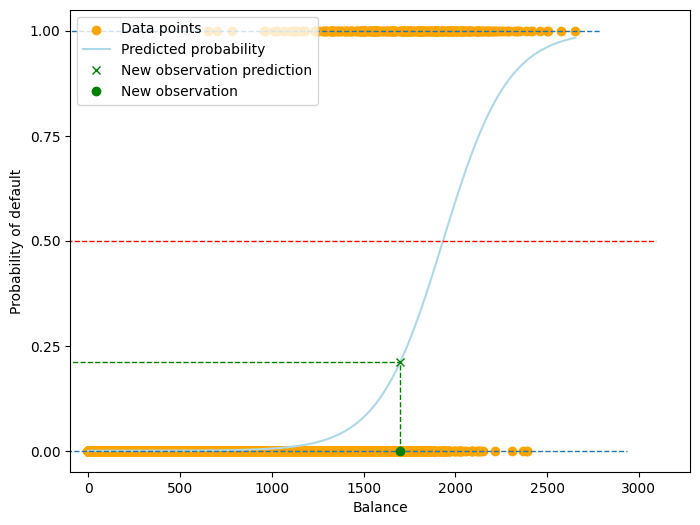

In [74]:
# Plot the graph
plt.figure(figsize=(8, 6))

# Scatter plot and line plot
plt.scatter(x, y, color='orange', label='Data points')
plt.plot(X_space, prob[:, 1], color='lightblue', label='Predicted probability')

# Add horizontal lines upper bound
plt.hlines(1, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1)
# Add horizontal lines lower bound
plt.hlines(0, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1)
# Add horizontal lines, the discriminant boundary
plt.hlines(0.5, xmin=plt.gca().get_xlim()[0],
           xmax=plt.gca().get_xlim()[1], linestyles='dashed', lw=1, colors='red')
# Add new observation
plt.vlines(new_balance_obs, ymin=0, ymax=prob_new_obs, linestyles='dashed', lw=1, colors='green')
plt.hlines(prob_new_obs, xmin=plt.gca().get_xlim()[0], xmax=new_balance_obs, linestyles='dashed', lw=1, colors='green')
plt.plot(new_balance_obs, prob_new_obs, 'gx', label='New observation prediction')
plt.plot(new_balance_obs, 0, 'go', label='New observation')


# Set labels and ticks
plt.ylabel('Probability of default')
plt.xlabel('Balance')
plt.yticks([0, 0.25, 0.5, 0.75, 1.])
plt.xlim(xmin=-100)

# Add legend
plt.legend(loc='upper left')

# Show plot
plt.show()

In [75]:
# Look at the parameters
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

classes:  [0 1]
coefficients:  [[0.00564782]]
intercept : [-10.91699938]


In [76]:
# statsmodels needs the intercept to be included in the X_train
X_train_w_intercept = sm.add_constant(pd.DataFrame(X_train))
est = sm.Logit(y_train.to_numpy(), X_train_w_intercept).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.077080
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.917012,0.420202,-25.980389,8.250468e-149,-11.740593,-10.093431
0,0.005648,0.000255,22.156487,9.032757e-109,0.005148,0.006147


# Multiple Logistic Regression

In [77]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = sm.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


# Confusion Matrix

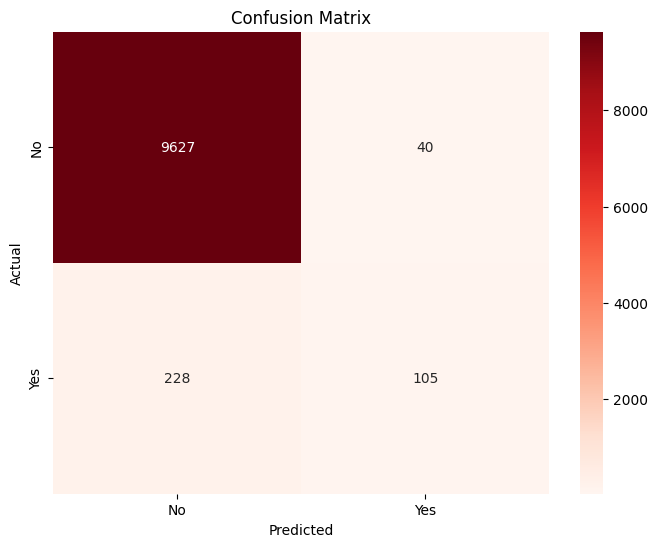

In [78]:
pred = est.predict(X_train)
y_pred = (pred > 0.5).astype(int)

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y, y_pred)

# Visualizza la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


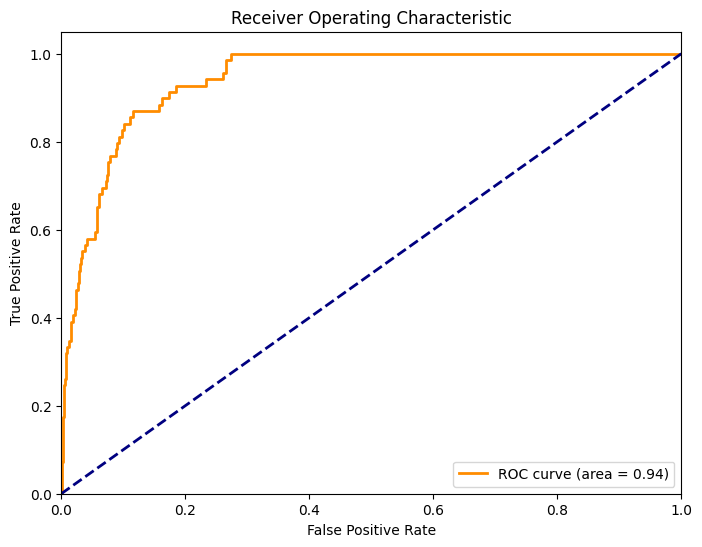

In [79]:

# Predict probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [80]:
# Calculate the Gini coefficient
gini = 2 * roc_auc - 1
print('Gini coefficient: %.2f' % gini)

Gini coefficient: 0.88
